In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
"""
(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7
(58.15%) 1,496,327 v2 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.2)-64(p=0.1)-7
(57.79%) 1,488,391 v3 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.5)-7

Main
(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7 
(58.18%) 1,323,015 v4 - 775-512(p=0.2)-512(p=0.3)-512(p=0.3)-512(p=0.3)-256(p=0.4)-7
v5 - 775-1024(p=0.2)-512(p=0.2)-512(p=0.2)-512(p=0.2)-256(p=0.5)-7
"""

'\n(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7\n(58.15%) 1,496,327 v2 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.2)-64(p=0.1)-7\n(57.79%) 1,488,391 v3 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.5)-7\n\nMain\n(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7 \n(58.18%) 1,323,015 v4 - 775-512(p=0.2)-512(p=0.3)-512(p=0.3)-512(p=0.3)-256(p=0.4)-7\nv5 - 775-1024(p=0.2)-512(p=0.2)-512(p=0.2)-512(p=0.2)-256(p=0.5)-7\n'

In [4]:
RUN_ID = "run_2026_01_22_probs_mlp_v4"
model_save_name = "probs_mlp_v4"

In [5]:
class ChessDataset(Dataset):
    def __init__(self, root_dir: Path, split: str, sigma: float = 0.6):
        self.root_dir = Path(root_dir)
        self.split = split
        self.sigma = sigma
        self.num_classes = 7
        self.class_indices = torch.arange(self.num_classes, dtype=torch.float32)
        self.X = np.load(self.root_dir / f"{self.split}_X.npy", mmap_mode='r')
        self.y = np.load(self.root_dir / f"{self.split}_y.npy", mmap_mode='r')
        self.scores = np.load(self.root_dir / f"{self.split}_scores.npy", mmap_mode='r')

    def __len__(self) -> int:
        return self.X.shape[0]

    def score_to_continuous_index(self, score: float) -> float:
        """
        Maps Centipawn score to a continuous index (e.g. 400cp -> 1.5).
        """
        
        if score >= 500: 
            # Fade from 0.5 (at 500) to 0.0 (at 700)
            return max(0.0, 0.5 - (score - 500) / 200.0)
        
        if score <= -500:
            # Fade from 5.5 (at -500) to 6.0 (at -700)
            return min(6.0, 5.5 + (-500 - score) / 200.0)
        
        # Interpolate the Middle Classes
        # 300 to 500  -> Maps to 1.5 to 0.5
        if score >= 300: return 1.5 - (score - 300) / 200.0
        # 100 to 300  -> Maps to 2.5 to 1.5
        if score >= 100: return 2.5 - (score - 100) / 200.0
        # -100 to 100 -> Maps to 3.5 to 2.5
        if score >= -100: return 3.5 - (score - (-100)) / 200.0
        # -300 to -100 -> Maps to 4.5 to 3.5
        if score >= -300: return 4.5 - (score - (-300)) / 200.0
        # -500 to -300 -> Maps to 5.5 to 4.5
        if score > -500: return 5.5 - (score - (-500)) / 200.0
        
        return 3.0 
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        score = self.scores[idx].item()
        target_idx = self.score_to_continuous_index(score)
        
        # Create Gaussian Distribution centered at target_idx
        dist = torch.exp(-((self.class_indices - target_idx) ** 2) / (2 * self.sigma ** 2))
        
        # Normalize so it sums to 1.0
        soft_target = dist / dist.sum()
        
        x_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        hard_label = torch.tensor(self.y[idx], dtype=torch.long)

        # return self.X[idx], self.y[idx]
        return x_tensor, soft_target, hard_label

In [6]:
BATCH_SIZE = 512
num_workers = 0 
ROOT_DIR = Path("./dataset_bitmaps_cp/")

train_dataset = ChessDataset(root_dir=ROOT_DIR, split="train")
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)

val_dataset = ChessDataset(root_dir=ROOT_DIR, split="val")
val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)

test_dataset = ChessDataset(root_dir=ROOT_DIR, split="test")
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [7]:
import time

start = time.time()
for i, (X, y, y_hard) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.03936772346496582


In [8]:
Xb, _, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype)

X batch shape: torch.Size([512, 775]) dtype: torch.float32
y batch shape: torch.Size([512]) dtype: torch.int64


In [9]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [11]:
class MLP(nn.Module):
    def __init__(self, input_shape=775, output_shape=7):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_shape, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Remove for non prob ablation
        y_true_class = torch.argmax(y, dim=-1)
        train_acc += (y_pred_class == y_true_class).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [13]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y, y_hard) in enumerate(dataloader):
            X, y, y_hard = X.to(device), y.to(device), y_hard.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y_hard).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [15]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   patience: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_acc = 0.0
    best_model_weights = None
    patience_counter = 0 
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.1, patience=3
    # )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=epochs,      
        eta_min=1e-6         
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        # scheduler.step(val_loss)
        scheduler.step()
        
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch: {epoch} | New Best Val Acc: {val_acc:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Acc: {best_val_acc:.4f}")

    return results

In [17]:
from torchinfo import summary

model = MLP(input_shape=775, 
            output_shape=7).to(device)

summary(model, input_size=(BATCH_SIZE,775))


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [512, 7]                  --
├─Sequential: 1-1                        [512, 7]                  --
│    └─Linear: 2-1                       [512, 1024]               794,624
│    └─BatchNorm1d: 2-2                  [512, 1024]               2,048
│    └─ReLU: 2-3                         [512, 1024]               --
│    └─Dropout: 2-4                      [512, 1024]               --
│    └─Linear: 2-5                       [512, 512]                524,800
│    └─BatchNorm1d: 2-6                  [512, 512]                1,024
│    └─ReLU: 2-7                         [512, 512]                --
│    └─Dropout: 2-8                      [512, 512]                --
│    └─Linear: 2-9                       [512, 512]                262,656
│    └─BatchNorm1d: 2-10                 [512, 512]                1,024
│    └─ReLU: 2-11                        [512, 512]          

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=0.01)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        patience=NUM_EPOCHS + 1,
                        device=device)

Starting Training: probs_mlp_v4


  1%|          | 1/100 [06:46<11:11:30, 406.97s/it]

Epoch: 0 | New Best Val Acc: 0.4722 (Saved)
Epoch: 0 | Train Loss: 1.4894 | Val Loss: 1.4241 | Val Acc: 0.4722


  2%|▏         | 2/100 [14:37<12:05:37, 444.26s/it]

Epoch: 1 | New Best Val Acc: 0.4986 (Saved)
Epoch: 1 | Train Loss: 1.4128 | Val Loss: 1.3862 | Val Acc: 0.4986


  3%|▎         | 3/100 [22:32<12:20:44, 458.19s/it]

Epoch: 2 | New Best Val Acc: 0.5108 (Saved)
Epoch: 2 | Train Loss: 1.3847 | Val Loss: 1.3685 | Val Acc: 0.5108


  4%|▍         | 4/100 [30:26<12:23:09, 464.47s/it]

Epoch: 3 | New Best Val Acc: 0.5150 (Saved)
Epoch: 3 | Train Loss: 1.3678 | Val Loss: 1.3570 | Val Acc: 0.5150


  5%|▌         | 5/100 [38:19<12:20:27, 467.65s/it]

Epoch: 4 | New Best Val Acc: 0.5233 (Saved)
Epoch: 4 | Train Loss: 1.3562 | Val Loss: 1.3495 | Val Acc: 0.5233


  6%|▌         | 6/100 [46:14<12:16:24, 470.05s/it]

Epoch: 5 | New Best Val Acc: 0.5262 (Saved)
Epoch: 5 | Train Loss: 1.3476 | Val Loss: 1.3430 | Val Acc: 0.5262


  7%|▋         | 7/100 [54:08<12:10:48, 471.49s/it]

Epoch: 6 | New Best Val Acc: 0.5308 (Saved)
Epoch: 6 | Train Loss: 1.3410 | Val Loss: 1.3389 | Val Acc: 0.5308


  8%|▊         | 8/100 [1:02:01<12:03:38, 471.94s/it]

Epoch: 7 | New Best Val Acc: 0.5337 (Saved)
Epoch: 7 | Train Loss: 1.3356 | Val Loss: 1.3334 | Val Acc: 0.5337


  9%|▉         | 9/100 [1:09:54<11:56:18, 472.30s/it]

Epoch: 8 | New Best Val Acc: 0.5377 (Saved)
Epoch: 8 | Train Loss: 1.3310 | Val Loss: 1.3263 | Val Acc: 0.5377


 10%|█         | 10/100 [1:17:48<11:49:22, 472.92s/it]

Epoch: 9 | New Best Val Acc: 0.5402 (Saved)
Epoch: 9 | Train Loss: 1.3269 | Val Loss: 1.3234 | Val Acc: 0.5402


 11%|█         | 11/100 [1:25:42<11:41:53, 473.18s/it]

Epoch: 10 | New Best Val Acc: 0.5407 (Saved)
Epoch: 10 | Train Loss: 1.3237 | Val Loss: 1.3221 | Val Acc: 0.5407


 12%|█▏        | 12/100 [1:33:37<11:34:55, 473.81s/it]

Epoch: 11 | New Best Val Acc: 0.5423 (Saved)
Epoch: 11 | Train Loss: 1.3208 | Val Loss: 1.3209 | Val Acc: 0.5423


 13%|█▎        | 13/100 [1:41:33<11:27:34, 474.20s/it]

Epoch: 12 | New Best Val Acc: 0.5456 (Saved)
Epoch: 12 | Train Loss: 1.3183 | Val Loss: 1.3157 | Val Acc: 0.5456


 14%|█▍        | 14/100 [1:49:28<11:20:21, 474.67s/it]

Epoch: No improvement. Patience 1/101
Epoch: 13 | Train Loss: 1.3160 | Val Loss: 1.3154 | Val Acc: 0.5451


 15%|█▌        | 15/100 [1:57:23<11:12:24, 474.64s/it]

Epoch: No improvement. Patience 2/101
Epoch: 14 | Train Loss: 1.3139 | Val Loss: 1.3153 | Val Acc: 0.5453


 16%|█▌        | 16/100 [2:05:16<11:03:40, 474.06s/it]

Epoch: 15 | New Best Val Acc: 0.5508 (Saved)
Epoch: 15 | Train Loss: 1.3119 | Val Loss: 1.3079 | Val Acc: 0.5508


 17%|█▋        | 17/100 [2:13:09<10:55:22, 473.76s/it]

Epoch: 16 | New Best Val Acc: 0.5515 (Saved)
Epoch: 16 | Train Loss: 1.3099 | Val Loss: 1.3082 | Val Acc: 0.5515


 18%|█▊        | 18/100 [2:21:03<10:47:41, 473.92s/it]

Epoch: No improvement. Patience 1/101
Epoch: 17 | Train Loss: 1.3080 | Val Loss: 1.3077 | Val Acc: 0.5509


 19%|█▉        | 19/100 [2:29:04<10:42:36, 476.00s/it]

Epoch: 18 | New Best Val Acc: 0.5517 (Saved)
Epoch: 18 | Train Loss: 1.3062 | Val Loss: 1.3073 | Val Acc: 0.5517


 20%|██        | 20/100 [2:36:57<10:33:26, 475.08s/it]

Epoch: 19 | New Best Val Acc: 0.5545 (Saved)
Epoch: 19 | Train Loss: 1.3050 | Val Loss: 1.3039 | Val Acc: 0.5545


 21%|██        | 21/100 [2:44:50<10:24:53, 474.60s/it]

Epoch: 20 | New Best Val Acc: 0.5548 (Saved)
Epoch: 20 | Train Loss: 1.3028 | Val Loss: 1.3017 | Val Acc: 0.5548


 22%|██▏       | 22/100 [2:52:44<10:16:35, 474.30s/it]

Epoch: 21 | New Best Val Acc: 0.5572 (Saved)
Epoch: 21 | Train Loss: 1.3021 | Val Loss: 1.2983 | Val Acc: 0.5572


 23%|██▎       | 23/100 [3:00:37<10:08:22, 474.05s/it]

Epoch: 22 | New Best Val Acc: 0.5572 (Saved)
Epoch: 22 | Train Loss: 1.3004 | Val Loss: 1.2974 | Val Acc: 0.5572


 24%|██▍       | 24/100 [3:08:30<10:00:05, 473.76s/it]

Epoch: No improvement. Patience 1/101
Epoch: 23 | Train Loss: 1.2991 | Val Loss: 1.2997 | Val Acc: 0.5562


 25%|██▌       | 25/100 [3:16:23<9:51:56, 473.55s/it] 

Epoch: 24 | New Best Val Acc: 0.5581 (Saved)
Epoch: 24 | Train Loss: 1.2978 | Val Loss: 1.2966 | Val Acc: 0.5581


 26%|██▌       | 26/100 [3:24:17<9:43:59, 473.51s/it]

Epoch: 25 | New Best Val Acc: 0.5611 (Saved)
Epoch: 25 | Train Loss: 1.2968 | Val Loss: 1.2927 | Val Acc: 0.5611


 27%|██▋       | 27/100 [3:32:11<9:36:14, 473.62s/it]

Epoch: No improvement. Patience 1/101
Epoch: 26 | Train Loss: 1.2957 | Val Loss: 1.2941 | Val Acc: 0.5599


 28%|██▊       | 28/100 [3:40:05<9:28:26, 473.70s/it]

Epoch: No improvement. Patience 2/101
Epoch: 27 | Train Loss: 1.2943 | Val Loss: 1.2920 | Val Acc: 0.5599


 29%|██▉       | 29/100 [3:47:58<9:20:23, 473.57s/it]

Epoch: No improvement. Patience 3/101
Epoch: 28 | Train Loss: 1.2934 | Val Loss: 1.2924 | Val Acc: 0.5610


 30%|███       | 30/100 [3:55:50<9:11:51, 473.02s/it]

Epoch: 29 | New Best Val Acc: 0.5627 (Saved)
Epoch: 29 | Train Loss: 1.2924 | Val Loss: 1.2894 | Val Acc: 0.5627


 31%|███       | 31/100 [4:03:41<9:03:18, 472.44s/it]

Epoch: No improvement. Patience 1/101
Epoch: 30 | Train Loss: 1.2912 | Val Loss: 1.2891 | Val Acc: 0.5625


 32%|███▏      | 32/100 [4:11:33<8:55:31, 472.52s/it]

Epoch: No improvement. Patience 2/101
Epoch: 31 | Train Loss: 1.2902 | Val Loss: 1.2898 | Val Acc: 0.5604


 33%|███▎      | 33/100 [4:19:28<8:48:19, 473.12s/it]

Epoch: 32 | New Best Val Acc: 0.5647 (Saved)
Epoch: 32 | Train Loss: 1.2889 | Val Loss: 1.2855 | Val Acc: 0.5647


 34%|███▍      | 34/100 [4:27:22<8:40:49, 473.48s/it]

Epoch: 33 | New Best Val Acc: 0.5654 (Saved)
Epoch: 33 | Train Loss: 1.2881 | Val Loss: 1.2852 | Val Acc: 0.5654


 35%|███▌      | 35/100 [4:35:13<8:32:09, 472.77s/it]

Epoch: 34 | New Best Val Acc: 0.5657 (Saved)
Epoch: 34 | Train Loss: 1.2871 | Val Loss: 1.2858 | Val Acc: 0.5657


 36%|███▌      | 36/100 [4:43:06<8:24:23, 472.87s/it]

Epoch: No improvement. Patience 1/101
Epoch: 35 | Train Loss: 1.2861 | Val Loss: 1.2861 | Val Acc: 0.5648


 37%|███▋      | 37/100 [4:50:57<8:15:54, 472.29s/it]

Epoch: No improvement. Patience 2/101
Epoch: 36 | Train Loss: 1.2852 | Val Loss: 1.2859 | Val Acc: 0.5636


 38%|███▊      | 38/100 [4:58:50<8:08:14, 472.49s/it]

Epoch: 37 | New Best Val Acc: 0.5661 (Saved)
Epoch: 37 | Train Loss: 1.2841 | Val Loss: 1.2858 | Val Acc: 0.5661


 39%|███▉      | 39/100 [5:06:41<7:59:48, 471.94s/it]

Epoch: No improvement. Patience 1/101
Epoch: 38 | Train Loss: 1.2830 | Val Loss: 1.2840 | Val Acc: 0.5652


 40%|████      | 40/100 [5:14:33<7:52:02, 472.04s/it]

Epoch: 39 | New Best Val Acc: 0.5671 (Saved)
Epoch: 39 | Train Loss: 1.2819 | Val Loss: 1.2816 | Val Acc: 0.5671


 41%|████      | 41/100 [5:22:22<7:43:16, 471.12s/it]

Epoch: No improvement. Patience 1/101
Epoch: 40 | Train Loss: 1.2810 | Val Loss: 1.2844 | Val Acc: 0.5660


 42%|████▏     | 42/100 [5:30:12<7:35:00, 470.70s/it]

Epoch: 41 | New Best Val Acc: 0.5678 (Saved)
Epoch: 41 | Train Loss: 1.2802 | Val Loss: 1.2814 | Val Acc: 0.5678


 43%|████▎     | 43/100 [5:38:02<7:27:01, 470.55s/it]

Epoch: 42 | New Best Val Acc: 0.5678 (Saved)
Epoch: 42 | Train Loss: 1.2792 | Val Loss: 1.2815 | Val Acc: 0.5678


 44%|████▍     | 44/100 [5:45:53<7:19:09, 470.53s/it]

Epoch: 43 | New Best Val Acc: 0.5679 (Saved)
Epoch: 43 | Train Loss: 1.2781 | Val Loss: 1.2807 | Val Acc: 0.5679


 45%|████▌     | 45/100 [5:53:44<7:11:24, 470.63s/it]

Epoch: 44 | New Best Val Acc: 0.5684 (Saved)
Epoch: 44 | Train Loss: 1.2772 | Val Loss: 1.2804 | Val Acc: 0.5684


 46%|████▌     | 46/100 [6:01:34<7:03:28, 470.53s/it]

Epoch: 45 | New Best Val Acc: 0.5690 (Saved)
Epoch: 45 | Train Loss: 1.2764 | Val Loss: 1.2795 | Val Acc: 0.5690


 47%|████▋     | 47/100 [6:09:24<6:55:34, 470.47s/it]

Epoch: 46 | New Best Val Acc: 0.5691 (Saved)
Epoch: 46 | Train Loss: 1.2754 | Val Loss: 1.2781 | Val Acc: 0.5691


 48%|████▊     | 48/100 [6:17:13<6:47:22, 470.04s/it]

Epoch: 47 | New Best Val Acc: 0.5701 (Saved)
Epoch: 47 | Train Loss: 1.2742 | Val Loss: 1.2769 | Val Acc: 0.5701


 49%|████▉     | 49/100 [6:25:04<6:39:43, 470.27s/it]

Epoch: 48 | New Best Val Acc: 0.5725 (Saved)
Epoch: 48 | Train Loss: 1.2733 | Val Loss: 1.2739 | Val Acc: 0.5725


 50%|█████     | 50/100 [6:32:57<6:32:34, 471.10s/it]

Epoch: No improvement. Patience 1/101
Epoch: 49 | Train Loss: 1.2721 | Val Loss: 1.2791 | Val Acc: 0.5671


 51%|█████     | 51/100 [6:40:47<6:24:30, 470.82s/it]

Epoch: 50 | New Best Val Acc: 0.5727 (Saved)
Epoch: 50 | Train Loss: 1.2710 | Val Loss: 1.2736 | Val Acc: 0.5727


 52%|█████▏    | 52/100 [6:48:38<6:16:41, 470.87s/it]

Epoch: 51 | New Best Val Acc: 0.5730 (Saved)
Epoch: 51 | Train Loss: 1.2701 | Val Loss: 1.2725 | Val Acc: 0.5730


 53%|█████▎    | 53/100 [6:56:29<6:08:47, 470.79s/it]

Epoch: No improvement. Patience 1/101
Epoch: 52 | Train Loss: 1.2688 | Val Loss: 1.2746 | Val Acc: 0.5717


 54%|█████▍    | 54/100 [7:04:18<6:00:39, 470.43s/it]

Epoch: No improvement. Patience 2/101
Epoch: 53 | Train Loss: 1.2679 | Val Loss: 1.2746 | Val Acc: 0.5706


 55%|█████▌    | 55/100 [7:12:09<5:52:48, 470.42s/it]

Epoch: No improvement. Patience 3/101
Epoch: 54 | Train Loss: 1.2666 | Val Loss: 1.2754 | Val Acc: 0.5707


 56%|█████▌    | 56/100 [7:19:59<5:44:54, 470.33s/it]

Epoch: 55 | New Best Val Acc: 0.5735 (Saved)
Epoch: 55 | Train Loss: 1.2655 | Val Loss: 1.2716 | Val Acc: 0.5735


 57%|█████▋    | 57/100 [7:27:50<5:37:15, 470.60s/it]

Epoch: No improvement. Patience 1/101
Epoch: 56 | Train Loss: 1.2644 | Val Loss: 1.2726 | Val Acc: 0.5730


 58%|█████▊    | 58/100 [7:35:43<5:29:53, 471.28s/it]

Epoch: 57 | New Best Val Acc: 0.5752 (Saved)
Epoch: 57 | Train Loss: 1.2634 | Val Loss: 1.2709 | Val Acc: 0.5752


 59%|█████▉    | 59/100 [7:43:34<5:21:56, 471.14s/it]

Epoch: No improvement. Patience 1/101
Epoch: 58 | Train Loss: 1.2619 | Val Loss: 1.2692 | Val Acc: 0.5749


 60%|██████    | 60/100 [7:51:24<5:13:56, 470.92s/it]

Epoch: No improvement. Patience 2/101
Epoch: 59 | Train Loss: 1.2610 | Val Loss: 1.2704 | Val Acc: 0.5739


 61%|██████    | 61/100 [7:59:14<5:05:48, 470.48s/it]

Epoch: 60 | New Best Val Acc: 0.5763 (Saved)
Epoch: 60 | Train Loss: 1.2599 | Val Loss: 1.2688 | Val Acc: 0.5763


 62%|██████▏   | 62/100 [8:07:04<4:57:58, 470.48s/it]

Epoch: 61 | New Best Val Acc: 0.5764 (Saved)
Epoch: 61 | Train Loss: 1.2585 | Val Loss: 1.2663 | Val Acc: 0.5764


 63%|██████▎   | 63/100 [8:14:53<4:49:49, 469.99s/it]

Epoch: 62 | New Best Val Acc: 0.5777 (Saved)
Epoch: 62 | Train Loss: 1.2575 | Val Loss: 1.2652 | Val Acc: 0.5777


 64%|██████▍   | 64/100 [8:22:48<4:42:53, 471.50s/it]

Epoch: No improvement. Patience 1/101
Epoch: 63 | Train Loss: 1.2565 | Val Loss: 1.2703 | Val Acc: 0.5740


 65%|██████▌   | 65/100 [8:30:47<4:36:21, 473.77s/it]

Epoch: No improvement. Patience 2/101
Epoch: 64 | Train Loss: 1.2550 | Val Loss: 1.2664 | Val Acc: 0.5770


 66%|██████▌   | 66/100 [8:38:41<4:28:31, 473.86s/it]

Epoch: No improvement. Patience 3/101
Epoch: 65 | Train Loss: 1.2540 | Val Loss: 1.2660 | Val Acc: 0.5754


 67%|██████▋   | 67/100 [8:46:35<4:20:33, 473.74s/it]

Epoch: 66 | New Best Val Acc: 0.5781 (Saved)
Epoch: 66 | Train Loss: 1.2526 | Val Loss: 1.2647 | Val Acc: 0.5781


 68%|██████▊   | 68/100 [8:54:30<4:12:51, 474.09s/it]

Epoch: 67 | New Best Val Acc: 0.5795 (Saved)
Epoch: 67 | Train Loss: 1.2515 | Val Loss: 1.2634 | Val Acc: 0.5795


 69%|██████▉   | 69/100 [9:02:26<4:05:22, 474.91s/it]

Epoch: No improvement. Patience 1/101
Epoch: 68 | Train Loss: 1.2500 | Val Loss: 1.2646 | Val Acc: 0.5772


 70%|███████   | 70/100 [9:10:27<3:58:17, 476.58s/it]

Epoch: 69 | New Best Val Acc: 0.5801 (Saved)
Epoch: 69 | Train Loss: 1.2490 | Val Loss: 1.2623 | Val Acc: 0.5801


 71%|███████   | 71/100 [9:18:32<3:51:37, 479.22s/it]

Epoch: No improvement. Patience 1/101
Epoch: 70 | Train Loss: 1.2478 | Val Loss: 1.2643 | Val Acc: 0.5780


 72%|███████▏  | 72/100 [9:26:34<3:43:58, 479.95s/it]

Epoch: No improvement. Patience 2/101
Epoch: 71 | Train Loss: 1.2466 | Val Loss: 1.2648 | Val Acc: 0.5772


 73%|███████▎  | 73/100 [9:34:37<3:36:27, 481.03s/it]

Epoch: No improvement. Patience 3/101
Epoch: 72 | Train Loss: 1.2455 | Val Loss: 1.2640 | Val Acc: 0.5782


 74%|███████▍  | 74/100 [9:42:41<3:28:43, 481.68s/it]

Epoch: No improvement. Patience 4/101
Epoch: 73 | Train Loss: 1.2441 | Val Loss: 1.2626 | Val Acc: 0.5791


 75%|███████▌  | 75/100 [9:50:45<3:20:59, 482.39s/it]

Epoch: No improvement. Patience 5/101
Epoch: 74 | Train Loss: 1.2429 | Val Loss: 1.2640 | Val Acc: 0.5777


 76%|███████▌  | 76/100 [9:58:45<3:12:42, 481.76s/it]

Epoch: No improvement. Patience 6/101
Epoch: 75 | Train Loss: 1.2417 | Val Loss: 1.2616 | Val Acc: 0.5793


 77%|███████▋  | 77/100 [10:06:47<3:04:43, 481.87s/it]

Epoch: 76 | New Best Val Acc: 0.5817 (Saved)
Epoch: 76 | Train Loss: 1.2405 | Val Loss: 1.2600 | Val Acc: 0.5817


 78%|███████▊  | 78/100 [10:14:50<2:56:50, 482.31s/it]

Epoch: No improvement. Patience 1/101
Epoch: 77 | Train Loss: 1.2395 | Val Loss: 1.2607 | Val Acc: 0.5812


 79%|███████▉  | 79/100 [10:22:55<2:49:05, 483.11s/it]

Epoch: No improvement. Patience 2/101
Epoch: 78 | Train Loss: 1.2382 | Val Loss: 1.2608 | Val Acc: 0.5805


 80%|████████  | 80/100 [10:31:02<2:41:26, 484.30s/it]

Epoch: No improvement. Patience 3/101
Epoch: 79 | Train Loss: 1.2372 | Val Loss: 1.2656 | Val Acc: 0.5755


 81%|████████  | 81/100 [10:39:07<2:33:21, 484.29s/it]

Epoch: No improvement. Patience 4/101
Epoch: 80 | Train Loss: 1.2363 | Val Loss: 1.2607 | Val Acc: 0.5802


 82%|████████▏ | 82/100 [10:47:04<2:24:40, 482.26s/it]

Epoch: 81 | New Best Val Acc: 0.5822 (Saved)
Epoch: 81 | Train Loss: 1.2352 | Val Loss: 1.2582 | Val Acc: 0.5822


 83%|████████▎ | 83/100 [10:55:05<2:16:32, 481.93s/it]

Epoch: No improvement. Patience 1/101
Epoch: 82 | Train Loss: 1.2341 | Val Loss: 1.2585 | Val Acc: 0.5812


 84%|████████▍ | 84/100 [11:03:07<2:08:30, 481.92s/it]

Epoch: No improvement. Patience 2/101
Epoch: 83 | Train Loss: 1.2328 | Val Loss: 1.2597 | Val Acc: 0.5803


 85%|████████▌ | 85/100 [11:11:13<2:00:47, 483.18s/it]

Epoch: No improvement. Patience 3/101
Epoch: 84 | Train Loss: 1.2322 | Val Loss: 1.2633 | Val Acc: 0.5770


 86%|████████▌ | 86/100 [11:19:17<1:52:45, 483.25s/it]

Epoch: 85 | New Best Val Acc: 0.5830 (Saved)
Epoch: 85 | Train Loss: 1.2313 | Val Loss: 1.2576 | Val Acc: 0.5830


 87%|████████▋ | 87/100 [11:27:21<1:44:47, 483.66s/it]

Epoch: No improvement. Patience 1/101
Epoch: 86 | Train Loss: 1.2304 | Val Loss: 1.2588 | Val Acc: 0.5805


 88%|████████▊ | 88/100 [11:35:28<1:36:55, 484.66s/it]

Epoch: No improvement. Patience 2/101
Epoch: 87 | Train Loss: 1.2294 | Val Loss: 1.2578 | Val Acc: 0.5826


 89%|████████▉ | 89/100 [11:43:32<1:28:47, 484.30s/it]

Epoch: No improvement. Patience 3/101
Epoch: 88 | Train Loss: 1.2287 | Val Loss: 1.2574 | Val Acc: 0.5821


 90%|█████████ | 90/100 [11:51:36<1:20:41, 484.12s/it]

Epoch: No improvement. Patience 4/101
Epoch: 89 | Train Loss: 1.2283 | Val Loss: 1.2568 | Val Acc: 0.5827


 91%|█████████ | 91/100 [11:59:40<1:12:38, 484.27s/it]

Epoch: No improvement. Patience 5/101
Epoch: 90 | Train Loss: 1.2277 | Val Loss: 1.2619 | Val Acc: 0.5780


 92%|█████████▏| 92/100 [12:07:46<1:04:38, 484.86s/it]

Epoch: 91 | New Best Val Acc: 0.5831 (Saved)
Epoch: 91 | Train Loss: 1.2269 | Val Loss: 1.2564 | Val Acc: 0.5831


 93%|█████████▎| 93/100 [12:15:45<56:20, 482.89s/it]  

Epoch: 92 | New Best Val Acc: 0.5836 (Saved)
Epoch: 92 | Train Loss: 1.2264 | Val Loss: 1.2560 | Val Acc: 0.5836


 94%|█████████▍| 94/100 [12:23:51<48:24, 484.02s/it]

Epoch: No improvement. Patience 1/101
Epoch: 93 | Train Loss: 1.2258 | Val Loss: 1.2586 | Val Acc: 0.5807


 95%|█████████▌| 95/100 [12:31:55<40:19, 483.89s/it]

Epoch: No improvement. Patience 2/101
Epoch: 94 | Train Loss: 1.2257 | Val Loss: 1.2598 | Val Acc: 0.5798


 96%|█████████▌| 96/100 [12:39:58<32:14, 483.55s/it]

Epoch: 95 | New Best Val Acc: 0.5837 (Saved)
Epoch: 95 | Train Loss: 1.2252 | Val Loss: 1.2557 | Val Acc: 0.5837


 97%|█████████▋| 97/100 [12:48:04<24:13, 484.38s/it]

Epoch: No improvement. Patience 1/101
Epoch: 96 | Train Loss: 1.2247 | Val Loss: 1.2596 | Val Acc: 0.5801


 98%|█████████▊| 98/100 [12:56:08<16:08, 484.32s/it]

Epoch: No improvement. Patience 2/101
Epoch: 97 | Train Loss: 1.2248 | Val Loss: 1.2560 | Val Acc: 0.5833


 99%|█████████▉| 99/100 [13:04:13<08:04, 484.49s/it]

Epoch: No improvement. Patience 3/101
Epoch: 98 | Train Loss: 1.2248 | Val Loss: 1.2572 | Val Acc: 0.5825


100%|██████████| 100/100 [13:12:18<00:00, 475.39s/it]

Epoch: No improvement. Patience 4/101
Epoch: 99 | Train Loss: 1.2247 | Val Loss: 1.2572 | Val Acc: 0.5825

Loaded best model weights with Val Acc: 0.5837


In [16]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [17]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Converts FEN to a 775-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(775, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0

    # Is there a check?
    vector[774] = 1.0 if board.is_check() else 0.0
    
    return vector

Model Prediction:  5
Stockfish Evaluation:  5


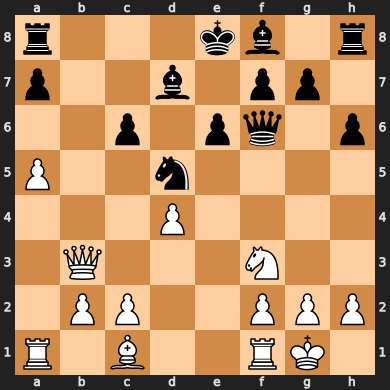

In [18]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [19]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, _, y_hard in val_dataloader:
        X = X.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(y_hard.numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.76      0.64      0.70     85601
           1       0.52      0.54      0.53     85601
           2       0.52      0.54      0.53     85601
           3       0.53      0.57      0.55     85601
           4       0.55      0.56      0.56     85601
           5       0.52      0.55      0.54     85601
           6       0.75      0.67      0.71     85601

    accuracy                           0.58    599207
   macro avg       0.59      0.58      0.59    599207
weighted avg       0.59      0.58      0.59    599207



In [20]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [21]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, _, y_hard in dataloader:
            X = X.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_hard.numpy())
            

    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [22]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": str(ROOT_DIR / "train_X.npy"),
    "val":   str(ROOT_DIR / "val_X.npy"),
    "test":  str(ROOT_DIR / "test_X.npy")
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/probs_mlp_v4/run_2026_01_22_probs_mlp_v4_config.json
[Logs] Saved training history to experiments/logs/probs_mlp_v4/run_2026_01_22_probs_mlp_v4_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        58.18%
[Results] Off-by-1 Acc:    88.05%
[Results] MAE:             0.6223
[Results] Latency:         0.0623 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 19760 samples
   - Off by 4: 7154 samples
   - Off by 5: 3564 samples
   - Off by 6: 1338 samples
[Results] Saved all metrics to experiments/results/probs_mlp_v4
------------------------------------------------------------


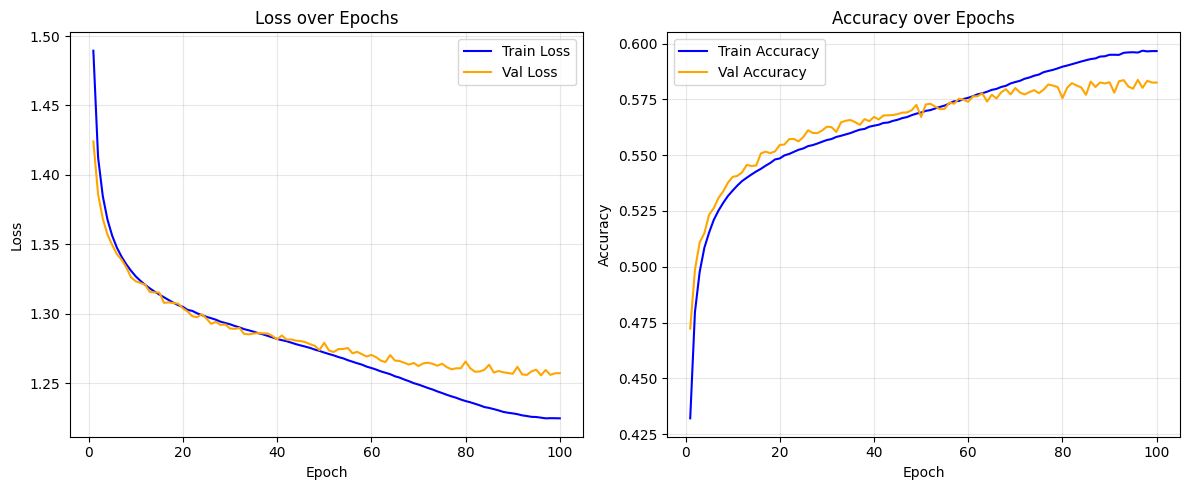

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()